# Homework 1, DS-GA 1012, Spring 2019

## Due Feburary 13, 2019 at 2pm (ET)
### Eva Wang sw2860


Download the data zip `DS-GA1012-hw1-data.zip`. Complete the following questions in the notebook and submit your completed notebook on NYU Classes.

## 1. Exploring effect of context size [30 pts]

We face many implicit and explicit design decisions in creating distributional word representations. For example, in lecture and in lab, we created word vectors using a co-occurence matrix built on neighboring pairs of words. We might suspect, however, that we can get more signal of word similarity by considering larger contexts than pairs of words.

__a__. Write `build_cooccurrence_matrix`, which generates the co-occurence matrix for a window of arbitrary size and for the vocabulary of `max_vocab_size` most frequent words. Feel free to modify the code used in lab [10 pts]

In [207]:
# function for loading dataset
def load_sst(data_file):
    with open(data_file, 'r') as data_fh:
        data_fh.readline() # skip the header
        data = [r.split('\t')[1] for r in data_fh.readlines()]
    return data

In [208]:
import time
import numpy as np
from collections import defaultdict
def build_cooccurrence_matrix(data, max_vocab_size, context_size=1):
    """ Build a co-occurrence matrix
    
    args:
        - data: iterable where each item is a list of tokens (string) 
        - max_vocab_size: maximum vocabulary size
        - context_size: window around a word that is considered context
            context_size=1 should consider pairs of adjacent words 
            
    returns:
        - co-occurrence matrix: numpy array where row i corresponds to the co-occurrence counts for word i"""
    #raise NotImplementedError
    # first, get occurence frequencies of each token, and summrize into a matrix (add 1 count for every word in context range)
    def get_token_frequencies():
        tok2freq = defaultdict(int)
        coocur_counts = defaultdict(lambda: defaultdict(int)) # provide default value for nonexistent key

        for datum in data:
            tokens = datum.strip().split() # we'll use whitespace to tokenize
            for i, tok in enumerate(tokens):
                tok2freq[tok] += 1
                for j in range(i, min(i+context_size+1,len(tokens))):
                    #coocur_counts[tok][tok] += 1
                    coocur_counts[tok][tokens[j]] += 1
                    coocur_counts[tokens[j]][tok] += 1
        return tok2freq, coocur_counts
    
    def prune_vocabulary(tok2freq, max_vocab_size):
        """ Prune vocab by taking max_vocab_size most frequent words to reduce dimension """
        tok_and_freqs = [(k, v) for k, v in tok2freq.items()]
        tok_and_freqs.sort(key = lambda x: x[1], reverse=True) # sorts in-place
        tok2idx = {tok: idx for idx, (tok, _) in enumerate(tok_and_freqs[:max_vocab_size])}
        idx2tok = {idx: tok for tok, idx in tok2idx.items()}
        return tok2idx, idx2tok
    
    def _build_coocurrence_mat(idx2tok, coocur_counts):
        #mat = [[coocur_counts[idx2tok[i]][idx2tok[j]] for j in range(len(idx2tok))] for i in range(len(idx2tok))]
        vocab_size = len(idx2tok)
        mat = [[0 for _ in range(vocab_size)] for _ in range(vocab_size)]
        for i in range(vocab_size - 1):
            for j in range(i+1, vocab_size):
                if coocur_counts[idx2tok[i]][idx2tok[j]]:
                    mat[i][j] = coocur_counts[idx2tok[i]][idx2tok[j]]
                    mat[j][i] = coocur_counts[idx2tok[i]][idx2tok[j]]
        # fill in the coocurrence matrix with coocur counts (in the range of top frequencies) coverted idx2tok
        return np.array(mat)
        
    print("Counting words...")
    start_time = time.time()
    tok2freq, coocur_counts = get_token_frequencies()
    print("\tFinished counting words in %.5f" % (time.time() - start_time))

    print("Pruning vocabulary...")
    tok2idx, idx2tok = prune_vocabulary(tok2freq, max_vocab_size)
    start_time = time.time()
    print("\tFinished pruning vocabulary in %.5f" % (time.time() - start_time))
    
    print("Building co-occurrence matrix...")
    start_time = time.time()
    coocur_mat = _build_coocurrence_mat(idx2tok, coocur_counts)
    print("\tFinished building co-occurrence matrix in %.5f" % (time.time() - start_time))
    return coocur_mat, tok2idx, idx2tok

Use your implementation of `build_cooccurrence_matrix` to generate the co-occurence matrix from the sentences of [SST](http://nlp.stanford.edu/~socherr/stanfordSentimentTreebank.zip) (file `datasetSentences.txt`) with `context_size=2` and `max_vocab_size=10000`. What is the co-occurrence count of the words "the" and "end"? 

In [209]:
data_file = 'datasetSentences.txt'
data = load_sst(data_file)
# find the co-occurence count of "the" and "end"
coocur_mat, tok2idx, idx2tok = build_cooccurrence_matrix(data, max_vocab_size=10000, context_size=2)

print("index of 'the'", tok2idx["the"])
print("index of 'end'", tok2idx["end"])
print("co-occurrence count of the words 'the' and 'end':", coocur_mat[2][201])

Counting words...
	Finished counting words in 2.22808
Pruning vocabulary...
	Finished pruning vocabulary in 0.00000
Building co-occurrence matrix...
	Finished building co-occurrence matrix in 28.34749
index of 'the' 2
index of 'end' 201
co-occurrence count of the words 'the' and 'end': 98


__b__. Plot the effect of varying context size in $\{1, 2, 3, 4\}$ (leaving all the other settings the same) on the quality of the learned word embeddings, as measured by performance (Spearman correlation) on the word similarity dataset [MTurk-771](http://www2.mta.ac.il/~gideon/mturk771.html) between human judgments and cosine similarity of the learned word vectors (see lab). [12 pts]

In [210]:
def vector_length(u):
    """Length (L2) of the 1d np.array `u`. Returns a new np.array with the 
    same dimensions as `u`."""
    return np.sqrt(np.dot(u, u))

def cosine(u, v):        
    """Cosine distance between 1d np.arrays `u` and `v`, which must have 
    the same dimensionality. Returns a float."""
    return 1.0 - (np.dot(u, v) / (vector_length(u) * vector_length(v)))

In [212]:
# evaluation: use cosine similarity
def load_word_similarity_dataset(data_file):
    with open(data_file, 'r') as data_fh:
        raw_data = data_fh.readlines()
    data = []
    trgs = []
    for datum in raw_data:
        datum = datum.strip().split(',')
        data.append((datum[0], datum[1]))
        trgs.append(float(datum[2]))
    return data, trgs

from scipy.stats import spearmanr

def evaluate_word_similarity(word_pairs, targets, mat, tok2idx):
    """ """
    preds = []
    trgs = []
    n_exs = 0
    for (word1, word2), trg in zip(word_pairs, targets):
        if word1 in tok2idx and word2 in tok2idx:
            pred_sim = 1 - cosine(mat[tok2idx[word1]], mat[tok2idx[word2]]) # cosine similarity
            preds.append(pred_sim)
            trgs.append(trg)
            n_exs += 1
    
    rho, pvalue = spearmanr(trgs, preds) # spearsman correlation 
    print("Evaluated on %d of %d examples" % (n_exs, len(word_pairs)))
    return rho



In [218]:
test_file = 'MTURK-771.csv'
test_data, test_trgs = load_word_similarity_dataset(test_file) #separate data pairs and socres
#coocur_mat, tok2idx, idx2tok = build_cooccurrence_matrix(data, max_vocab_size=10000, context_size=2)
#evaluate_word_similarity(test_data, test_trgs, coocur_mat, tok2idx)
import matplotlib.pyplot as plt
context_sizes = [1,2,3,4]
rho_list = []
for window in context_sizes:
    coocur_mat, tok2idx, idx2tok = build_cooccurrence_matrix(data, max_vocab_size=10000, context_size=window)
    rho = evaluate_word_similarity(test_data, test_trgs, coocur_mat, tok2idx)
    rho_list.append(rho)  

Counting words...
	Finished counting words in 0.58497
Pruning vocabulary...
	Finished pruning vocabulary in 0.00000
Building co-occurrence matrix...
	Finished building co-occurrence matrix in 27.25204
Evaluated on 248 of 771 examples
Counting words...
	Finished counting words in 0.61488
Pruning vocabulary...
	Finished pruning vocabulary in 0.00000
Building co-occurrence matrix...
	Finished building co-occurrence matrix in 26.89396
Evaluated on 248 of 771 examples
Counting words...
	Finished counting words in 0.89776
Pruning vocabulary...
	Finished pruning vocabulary in 0.00000
Building co-occurrence matrix...
	Finished building co-occurrence matrix in 25.82140
Evaluated on 248 of 771 examples
Counting words...
	Finished counting words in 0.97620
Pruning vocabulary...
	Finished pruning vocabulary in 0.00000
Building co-occurrence matrix...
	Finished building co-occurrence matrix in 25.49470
Evaluated on 248 of 771 examples


Text(0.5,0,'context_sizes')

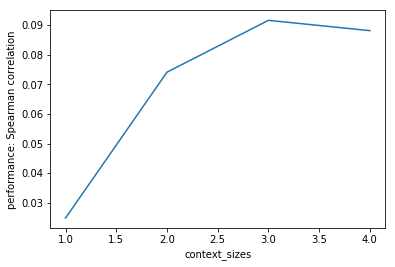

In [234]:
plt.plot(context_sizes,rho_list) 
plt.ylabel('performance: Spearman correlation')
plt.xlabel('context_sizes')

__c__. Briefly discuss the pros and cons of varying (i) the context size (ii) the vocabulary size (iii) using bigrams instead of unigrams (iv) using subword tokens instead of words. [8 pts]

__(i)__.  context size 
    - Closer words are generally considered to be more relevant to a word's meaning, so a larger context size will capture more information. 
    - However, when the context size getting too large, word embedding will be affected by irrelevent neighbours.
    - Smaller context size also makes computations faster.
    - Thus, the key is to find the optimal point, which in our case, the word embedding performs best when context size = 3 
    
__(ii)__. vocabulary size
    - Compared to small vocabulary, larger vocabulary generally has less bias and better perforamnce for understanding language, but takes more computation.

__(iii)__. use bigrams:    
    - Pros: Understand pairs of words by incorporting neighbor words 
    - Cons: too many infrequent bigrams can be noisy (many of the bi-grams never occur). Higher computational cost

__(iv)__. use subword tokens
    - Pros: take sub-word information into account. Character embedding is especially effective in single sentence input tasks.
    - Cons: adds additional computation. Subword modeling without pretrained word embedding can be biased since it does not take the meaning of words into account.

## 2. Pointwise Mutual Information [20 pts]

In lecture, we introduced __pointwise mutual information__ (PMI), which addresses the issue of normalization removing information about absolute magnitudes of counts. The PMI for word $\times$ context pair $(w,c)$ is 

$$\log\left(\frac{P(w,c)}{P(w) \cdot P(c)}\right)$$

with $\log(0) = 0$. This is a measure of how far that cell's value deviates from what we would expect given the row and column sums for that cell.

__a__. Implement `pmi`, a function which takes in a co-occurence matrix and returns the matrix with PMI normalization applied. [15 pts]

In [224]:
def pmi(mat,ppmi= False):
    """Pointwise mutual information
    
    args:
        - mat: 2d np.array to apply PMI
        
    returns:
        - pmi_mat: matrix of same shape with PMI applied
    """    
    #raise NotImplementedError
    
    total_count = np.sum(mat)
    word_prob = np.sum(mat,axis = 1)/total_count
    context_prob = np.sum(mat, axis =0)/total_count    
    pc_prob = mat/total_count
    pmi_mat = np.zeros((len(word_prob),len(context_prob)))
    for i in range(len(word_prob)):
        for j in range(len(context_prob)):
            if pc_prob[i][j]/(word_prob[i]*context_prob[j]) ==0:
                pmi_mat[i][j] == 0
            else:
                if ppmi == True:
                    pmi_mat[i][j] = max(0.0, np.log2(pc_prob[i][j]/(word_prob[i]*context_prob[j])))# use base-2 log
                else:
                    pmi_mat[i][j] = np.log2(pc_prob[i][j]/(word_prob[i]*context_prob[j]))
                
     
    return pmi_mat
    

Apply PMI to the co-occurence matrix computed above with `context_size=1`. What is the PMI between the words "the" and "end"?

In [225]:
coocur_mat, tok2idx, idx2tok = build_cooccurrence_matrix(data, max_vocab_size=10000, context_size=1)

Counting words...
	Finished counting words in 0.77883
Pruning vocabulary...
	Finished pruning vocabulary in 0.00000
Building co-occurrence matrix...
	Finished building co-occurrence matrix in 28.53604


In [226]:
coocur_mat_pmi = pmi(coocur_mat)
print("PMI between 'the' and 'end'",coocur_mat_pmi[tok2idx["the"]][tok2idx["end"]])

/Users/evashuyuwang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
/Users/evashuyuwang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in double_scalars


PMI between 'the' and 'end' 3.057042629431626


__b__. We also consider an extension of PMI, positive PMI (PPMI), that maps all negative PMI values to 0.0 ([Levy and Goldberg 2014](http://papers.nips.cc/paper/5477-neural-word-embedding-as-implicit-matrix-factorization)). 
Write `ppmi`, which is the same as `pmi` except it applies PPMI instead of PMI (feel free to implement it as an option of `pmi`). What is the PMI of the words "the" and "start"? The PPMI? [5 pts]

In [242]:
# PPMI is implemented as an option of pmi

print("index of 'the'", tok2idx["the"])
print("index of 'start'", tok2idx["start"])

coocur_mat_pmi = pmi(coocur_mat, ppmi = False)
coocur_mat_ppmi = pmi(coocur_mat, ppmi = True)

print("PMI between 'the' and 'start'",coocur_mat_pmi[2][670])
print("PPMI between 'the' and 'start'",coocur_mat_ppmi[2][670])


index of 'the' 2
index of 'start' 670


/Users/evashuyuwang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
/Users/evashuyuwang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in double_scalars
/Users/evashuyuwang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars


PMI between 'the' and 'start' 0.98517981040929
PPMI between 'the' and 'start' 0.98517981040929


## 3. Analyzing PMI [25 pts]

__a__. Consider the matrix `np.array([[1.0, 0.0, 0.0], [1000.0, 1000.0, 4000.0], [1000.0, 2000.0, 999.0]])`. Reweight this matrix using `ppmi`. (i) What is the value obtained for cell `[0,0]`, and (ii) give a brief description for what is likely problematic about this value. [10 pts]

In [232]:
mat_3 = np.array([[1.0, 0.0, 0.0], [1000.0, 1000.0, 4000.0], [1000.0, 2000.0, 999.0]])
mat_3_ppmi = pmi(mat_3,ppmi=True)
print(mat_3_ppmi)
print("value obtained for cell [0,0]:",mat_3_ppmi[0][0])

[[2.32120693 0.         0.        ]
 [0.         0.         0.41532607]
 [0.32156765 0.73732631 0.        ]]
value obtained for cell [0,0]: 2.3212069276437086


- The PMI value is biased towards infrequent events, which means very rare words have high PMI values.

__b__. Give a suggestion for dealing with the problematic value and explain why it deals with this. Demonstrate your suggestion empirically [10 pts]

In [235]:
# Use Laplace smoothing to reduce the bias of PMI towards infrequent term.
mat_laplace = mat_3 + 1 # Adding a constant positive value to raw frequencies before calculating the probability.
ppmi_laplace = pmi(mat_laplace,ppmi=True)
print(ppmi_laplace)

[[1.32034343 0.         0.        ]
 [0.         0.         0.41539784]
 [0.32106423 0.73682146 0.        ]]


- As shown in the results above, by using Laplace smoothing, the value obtained for cell [0,0] is smaller ( and less biased ). This is because the magnitued of the push by the constant depends on the raw frequency. Small frequency is adjusted on a larger scale, larger frequency is adjusted by smaller push.

__c__. Consider starting with a word-word co-occurence matrix and applied PMI to this matrix. (i) Which of the following describe the resulting vectors: sparse, dense, high-dimensional, low-dimensional (ii) If you wanted the opposite style of representation, what could you do? [5 pts]


_(i)_ Sparse, high-dimensional

_(ii)_ Dimensionality reduction: SVD, LSA, etc.




## 4. Word Analogy Evaluation [25 pts]

Word analogies provide another kind of evaluation for distributed representations. Here, we are given three vectors A, B, and C, in the relationship

_A is to B as C is to __ _

and asked to identify the fourth that completes the analogy. These analogies are by and large substantially easier than the classic brain-teaser analogies that used to appear on tests like the SAT, but it's still an interesting, demanding
task. 

The core idea is that we make predictions by creating the vector

$$(A - B) + C$$ 

and then ranking all vectors based on their distance from this new vector, choosing the closest as our prediction.

__a__. Implement the function `analogy_completion`. [9 pts]

In [197]:
def analogy_completion(a, b, c, mat_dic = glove_vecs,distfunc=cosine):
    """Compute ? in 
    a is to b as c is to ? 
    as the closest to (b-a) + c
    """
    #raise NotImplementedError
    # compare all vectors to (a-b)+c
    tok_list = list(mat_dic.keys()) 
    for x in (a,b,c):
        if x not in tok_list:
            raise ValueError('%s is not in this VSM' % x)
    
    a_vec = mat_dic[a]
    b_vec = mat_dic[b]
    c_vec = mat_dic[c]
    
    new_vec =  (b_vec-a_vec) + c_vec  
    dists = [(tok_list[i], distfunc(new_vec, mat_dic[tok_list[i]])) for i in range(len(mat_dic)) if tok_list[i] not in (a,b,c)]
    
    return sorted(dists, key=lambda x: x[1], reverse=False)

__b__. Our simple word embeddings likely won't perform well on this task. Let's instead look at some high quality pretrained word embeddings. Write code to load 300-dimensional [GloVe word embeddings](http://nlp.stanford.edu/data/glove.840B.300d.zip) trained on 840B tokens. Each line of the file is formatted as a word followed by 300 floats that make up its corresponding word embedding (all space delimited). The entries of GloVe word embeddings are not counts, but instead are learned via machine learning. Use your `analogy_completion` code to complete the following analogies using the GloVe word embeddings. [6 pts]

- "Beijing" is to "China" as "Paris" is to ?
- "gold" is to "first" as "silver" is to ?
- "Italian" is to "mozzarella" as "American" is to ?
- "research" is to "fun" as "engineering" is to ?

In [191]:
def load_glove(glove_file, n_vecs=50000): #top 50000 tokens
    """ """
    tok2vec = {}
    with open(glove_file, 'r') as glove_fh:
        for i, row in enumerate(glove_fh):
            word, vec = row.split(' ', 1)
            tok2vec[word] = np.array([float(n) for n in vec.split(' ')])
            if i >= n_vecs:
                break
    return tok2vec
glove_file = "glove.840B.300d.txt"
glove_vecs = load_glove(glove_file, n_vecs=50000)

In [193]:
# implement analogy_completion
# use GloVe word embeddings instead of co-occurence counts
r1 = analogy_completion("Beijing", "China", "Paris", mat_dic= glove_vecs,distfunc=cosine)
print(r1[0])
r2 = analogy_completion("gold", "first", "silver", mat_dic= glove_vecs,distfunc=cosine)
print(r2[0])
r3 = analogy_completion("Italian","mozzarella","American", mat_dic= glove_vecs,distfunc=cosine)
print(r3[0])
r4 = analogy_completion("research","fun", "engineering", mat_dic= glove_vecs,distfunc=cosine)
print(r4[0])

('France', 0.27706330530641043)
('second', 0.3024389409663598)
('cheddar', 0.4171742770336405)
('awesome', 0.5027277614731709)


c. Let's get a more quantitative, aggregate sense of the quality of GloVe embeddings. Load the analogies from `gram6-nationality-adjective.txt` and evaluate GloVe embeddings. Report the mean reciprocal rank of the correct answer (the last word on each line) for each analogy. [10 pts]

__Solution__

In [240]:
def analogy_evaluation(glove_vecs, test_file, verbose=False):
    """Basic analogies evaluation for a file `src_filename `
    in `question-data/`.
    
    Parameters
    ----------    
    mat : 2d np.array
        The VSM being evaluated.
        
    rownames : list of str
        The names of the rows in `mat`.
        
    src_filename : str
        Basename of the file to be evaluated. It's assumed to be in
        `vsmdata_home`/question-data.
        
    distfunc : function mapping vector pairs to floats (default: `cosine`)
        The measure of distance between vectors. Can also be `euclidean`, 
        `matching`, `jaccard`, as well as any other distance measure 
        between 1d vectors.
    
    Returns
    -------
    (float, float)
        The first is the mean reciprocal rank of the predictions and 
        the second is the accuracy of the predictions.
    
    """
    data = [line.split() for line in open(test_file).read().splitlines()]
    ranks = []
    acc = defaultdict(int)
    preds = []
    n_exs = 0
    tok_list = list(glove_vecs.keys())
    for datum in data:
        a = datum[0]
        b = datum[1]
        c = datum[2]
        trg = datum[3]
        if all(x in tok_list for x in (a,b,c,trg)): # only include rows with all tokens in the token list
            preds = analogy_completion(a, b, c, mat_dic = glove_vecs,distfunc=cosine)
            acc[preds[0][0] == trg] += 1
            predicted_words, _ = zip(*preds)
            ranks.append(predicted_words.index(trg))
            n_exs += 1
        
    # Return the mean reciprocal rank
    mrr = np.mean(1.0/(np.array(ranks)+1))
    print("Evaluated on %d of %d examples" % (n_exs, len(data)))
    return (mrr,acc)

In [241]:
analogy_evaluation(glove_vecs, "gram6-nationality-adjective.txt")

Evaluated on 234 of 1599 examples


(0.9533545848238831, defaultdict(int, {True: 219, False: 15}))